# Amount Drive and Import Libraries

In [0]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!pip install torch
!pip3 install torchvision
!pip install opencv-python

# import libraries
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys

import torch
from PIL import Image

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Change Path Here
---
Path to the directory of train set and test set and also the path where to store trained model

In [0]:
train_input_dir = '/content/drive/My Drive/csc420/cat_data/Train/input/'
train_mask_dir = '/content/drive/My Drive/csc420/cat_data/Train/mask/'

test_input_dir = '/content/drive/My Drive/csc420/cat_data/Test/input/'
test_mask_dir = '/content/drive/My Drive/csc420/cat_data/Test/mask/'

saved_unet_dice_path = '/content/drive/My Drive/csc420/unet_dice_data_aug.model'
saved_unet_bce_path = '/content/drive/My Drive/csc420/unet_bce_data_aug.model'

# Data Augmentation Functions
Four augmentation techniques used:

*   flip (horizontal or vertical)
*   rotation with random degree
*   Random Gaussian noise
*   Crop image with random size




In [0]:
import random

# Return flipped img and its corresponding mask randomly
def random_flip(img, mask):
    seed = random.randint(0, 1)
    flag = Image.FLIP_LEFT_RIGHT if seed is 0 else Image.FLIP_TOP_BOTTOM
    
    return img.transpose(flag), mask.transpose(flag)

# Return rotated img and its corresponding mask randomly
def random_rotate(img, mask):
    rand_degree = random.randint(0, 359)  
    return img.rotate(rand_degree), mask.rotate(rand_degree)

# Return img and its corresponding mask with a random guassian noise
def random_noise(img, mask):
    img_np = np.array(img)
    mask_np = np.array(mask)
 
    noisy_img = np.zeros(img_np.shape)
    normed_noisy_img = np.zeros(img_np.shape)
    # Normalized the image
    img_np = cv.normalize(img_np.astype(np.float), img_np, 0, 1, cv.NORM_MINMAX)

    # Add a gaussian noise
    noise = np.random.normal(0, 0.08, img_np.shape)
    noisy_img = cv.normalize((img_np+noise), noisy_img, 0, 1, cv.NORM_MINMAX)

    # clip the matrix to 0 and 255
    noisy_img = np.clip(noisy_img * 255, 0, 255)

    # Revert image back to PIL image
    return Image.fromarray(noisy_img.astype('uint8'), 'RGB'), mask

# Return randomly cropped img and its corresponding mask
def random_crop(img, mask):
    img_np = np.array(img)
    mask_np = np.array(mask)
        
    h, w, _ = img_np.shape
    
    # Compute random new height and width
    size = random.uniform(0.5, 1)
    new_h = int(h * size)
    new_w = int(w * size)
 
    new_img = np.zeros(img_np.shape)
    new_mask = np.zeros(mask_np.shape)
    
    # Choose top left corner point of patch with new size randomly
    new_y = random.randint(0, h - new_h)
    new_x = random.randint(0, w - new_w)

    # Find patch
    img_patch = img_np[new_y : new_y + new_h, new_x : new_x + new_w]
    mask_patch = mask_np[new_y : new_y + new_h, new_x : new_x + new_w]

    # Reshape
    new_img = cv.resize(img_patch, (w, h), interpolation=cv.INTER_CUBIC)
    new_mask = cv.resize(mask_patch, (w, h), interpolation=cv.INTER_CUBIC)
    
    # Revert image back to pil image
    new_pil_img = Image.fromarray(new_img, 'RGB')
    new_pil_mask = Image.fromarray(new_mask, 'L')
    
    return new_pil_img, new_pil_mask
  

# Load Data for Training and Testing

---
Load training set and test set images and masks.

## Customized Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms 

# Define customized dataset
class CatAugDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        img_ids = [int(f.split('.')[-2]) for f in os.listdir(img_dir)]

        first_img = os.listdir(img_dir)[0]
        first_mask = os.listdir(mask_dir)[0]
        img_name = first_img.split('.')[0]
        img_extension = first_img.split('.')[-1]
        mask_name = first_mask.split('.')[0]
        mask_extension = first_mask.split('.')[-1]
        self.imgs = []
        self.masks = []
        self.transform = transform

        # add corresponding image and mask path into list for such id
        for id in img_ids:
            img = Image.open(img_dir+img_name+'.'+str(id)+'.'+img_extension)
            mask = Image.open(mask_dir+mask_name+'.'+str(id)+'.'+mask_extension)
            fliped_img, fliped_mask = random_flip(img, mask)
            rotated_img, rotated_mask = random_rotate(img, mask)
            noisy_img, noisy_mask = random_noise(img, mask)
            crop_img, crop_mask = random_crop(img, mask)
            self.imgs += [img, fliped_img, rotated_img, noisy_img, crop_img]
            self.masks += [mask, fliped_mask, rotated_mask, noisy_mask, crop_mask]                                  

    def __getitem__(self, index):
        img = self.imgs[index]
        mask = self.masks[index]

        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)
      
      
class CatDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        img_ids = [int(f.split('.')[-2]) for f in os.listdir(img_dir)]

        first_img = os.listdir(img_dir)[0]
        first_mask = os.listdir(mask_dir)[0]
        img_name = first_img.split('.')[0]
        img_extension = first_img.split('.')[-1]
        mask_name = first_mask.split('.')[0]
        mask_extension = first_mask.split('.')[-1]
        self.img_files = []
        self.mask_files = []
        self.transform = transform
        
        # add corresponding image and mask path into list for such id
        for id in img_ids:
            self.img_files.append(img_dir+img_name+'.'+str(id)+'.'+img_extension)
            self.mask_files.append(mask_dir+mask_name+'.'+str(id)+'.'+mask_extension)
        
        
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)
            
        return img, mask

    def __len__(self):
        return len(self.img_files)

## Load Data from Given Path

In [8]:
# load training input images and mask
img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
  
train_dataset = CatAugDataset(train_input_dir, train_mask_dir, transform=img_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

inputs, masks = next(iter(train_loader))
print(len(train_loader))
print(inputs.shape, masks.shape)

# load test input images and mask
test_dataset = CatDataset(test_input_dir, test_mask_dir, transform=img_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

inputs, masks = next(iter(test_loader))
print(len(test_loader))
print(inputs.shape, masks.shape)

75
torch.Size([4, 3, 128, 128]) torch.Size([4, 1, 128, 128])
6
torch.Size([4, 3, 128, 128]) torch.Size([4, 1, 128, 128])


# Building U-Net
---
Same U-Net model from 420a3q1.1.

In [0]:
from torch import nn, optim

def double_conv(in_channel, out_channel):
  return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU())

def up_sample(in_channel, out_channel):
  return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, 2, stride=2, padding=0),
            nn.ReLU())


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down_layer1 = double_conv(3, 64)
        self.down_layer2 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(64, 128)
        )
        self.down_layer3 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(128, 256)
        )
        self.down_layer4 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(256, 512)
        )
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(512, 1024)
        )
        self.up_sample1 = up_sample(1024, 512)
        self.up_sample2 = up_sample(512, 256)
        self.up_sample3 = up_sample(256, 128)
        self.up_sample4 = up_sample(128, 64)
        self.up_layer1 = double_conv(1024, 512)
        self.up_layer2 = double_conv(512, 256)
        self.up_layer3 = double_conv(256, 128)
        self.up_layer4 = nn.Sequential(
            double_conv(128, 64),
            nn.Conv2d(64, 1, kernel_size=1, padding=0)
        )
        
    def forward(self, img):
        # Contracting/downsampling path
        down_1 = self.down_layer1(img)
        down_2 = self.down_layer2(down_1)
        down_3 = self.down_layer3(down_2)
        down_4 = self.down_layer4(down_3)
        
        bottleneck = self.bottleneck(down_4)
        bottleneck_upsample = self.up_sample1(bottleneck)
        bottleneck_upsample = torch.cat((bottleneck_upsample, down_4), dim=1)
        
        # Expanding/upsampling path
        up_1 = self.up_layer1(bottleneck_upsample)
        up_1_upsample = self.up_sample2(up_1)
        up_1_upsample = torch.cat((up_1_upsample, down_3), dim=1)
        
        up_2 = self.up_layer2(up_1_upsample)
        up_2_upsample = self.up_sample3(up_2)
        up_2_upsample = torch.cat((up_2_upsample, down_2), dim=1)
        
        up_3 = self.up_layer3(up_2_upsample)
        up_3_upsample = self.up_sample4(up_3)
        up_3_upsample = torch.cat((up_3_upsample, down_1), dim=1)
        
        out = self.up_layer4(up_3_upsample)
        out = nn.Sigmoid()(out)
        return out

# Training U-Net
---
With self-implemented loss function:


*   Binary Cross Entropy
*   Sørensen–Dice-coefficient 

## Define Two Loss Functions and Train Function

In [0]:
# loss functions
def cross_entropy_loss(predicts, targets):
    # pixel-wise cross entropy
    norm_pred = predicts / predicts.max()
    # loss = -(ylog(p)+(1-y)log(1-p)) for a single predict with 2 class
    # computed loss as the average of all cross-entropies in the sample
    loss = -torch.mean((targets)*torch.log(predicts) + (1-targets)*torch.log(1-predicts)).sum()
        
    return loss
  
def dice_loss(predicts, targets):
    smooth = 1.
    predicts = predicts.reshape(-1)
    targets = targets.reshape(-1)
    intersection = torch.dot(predicts, targets)

    score = (2. * intersection + smooth) / (predicts.sum() + targets.sum() + smooth)
    return 1. - score
  

def train_unet_with_eval(model, 
                         trainloader, 
                         testloader, 
                         train_criterion, 
                         test_criterion, 
                         device,
                         model_path='/content/drive/My Drive/csc420/unet.model',
                         epochs=5):
    print("Start Training ...")
    print("trianloader length:{}".format(len(trainloader)))
    print("testloader length:{}".format(len(testloader)))
    print("saved model path:{}".format(model_path))
    
    optimizer = optim.Adam(model.parameters())  
    model.train()
    
    min_eval_loss = np.inf
    
    train_losses, test_losses = [], []
    for e in range(epochs):
#         print('Epoch {}/{}'.format(e+1, epochs))
#         print('=' * 20)

        running_loss = 0
        for i, data in enumerate(trainloader, 0):
#             print(i)
#             print("===Trainging phase===")
            optimizer.zero_grad()
            inputs, masks = data
            inputs = inputs.to(device)
            masks = masks.to(device)

            outputs = model(inputs)
#             print(outputs)
#             print("outputs size: {}".format(outputs.shape))
            loss = train_criterion(outputs, masks)
#             print("computed trainging loss: {}".format(loss.item()))

            # backward and optimize for training
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_losses.append(running_loss/len(trainloader))
        else:
            # Evaluate model after every epoch
#             print("===Predicting phase===")

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss = 0
                accuracy = 0
                for i, data in enumerate(testloader, 0):
#                     print(i)
                    test_inputs, test_masks = data
                    test_inputs = test_inputs.to(device)
                    test_masks = test_masks.to(device)

                    # predict and caculate loss
                    eval_predicts = model(test_inputs)
                    eval_loss = test_criterion(eval_predicts, test_masks)
#                     print("computed loss: {}".format(eval_loss.item()))
                    
                    test_loss += eval_loss.item()
                
                test_loss = test_loss/len(testloader)
                test_losses.append(test_loss)

                # save model with smallest valuation loss
                if test_loss < min_eval_loss:
                    print("Epoch{}: Save best model with test loss: {:.3f}.. ".format(e+1 , test_loss))
                    min_eval_loss = test_loss
                    torch.save(model.state_dict(), model_path)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss))
#         print("")

    print("List of train loss:{}".format(train_losses))
    print("List of test loss:{}".format(test_losses))
    # load best model weights
    print('Best valuation loss: {:4f}'.format(min_eval_loss))

## Build U-Net Model and Call Train UNet function

In [12]:
# build a u-net
model = UNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# train u-net with given input and masks and with dice loss as loss function
print("Train unet with dice coefficient as loss function...")
train_unet_with_eval(model,
                     train_loader, 
                     test_loader, 
                     dice_loss, 
                     dice_loss,
                     device,
                     model_path=saved_unet_dice_path,
                     epochs=10)

Train unet with dice coefficient as loss function...
Start Training ...
trianloader length:75
testloader length:6
saved model path:/content/drive/My Drive/csc420/unet_dice_data_aug.model
Epoch1: Save best model with test loss: 0.337.. 
Epoch: 1/10..  Training Loss: 0.398..  Test Loss: 0.337.. 
Epoch2: Save best model with test loss: 0.308.. 
Epoch: 2/10..  Training Loss: 0.314..  Test Loss: 0.308.. 
Epoch3: Save best model with test loss: 0.267.. 
Epoch: 3/10..  Training Loss: 0.290..  Test Loss: 0.267.. 
Epoch: 4/10..  Training Loss: 0.281..  Test Loss: 0.280.. 
Epoch: 5/10..  Training Loss: 0.270..  Test Loss: 0.284.. 
Epoch: 6/10..  Training Loss: 0.263..  Test Loss: 0.303.. 
Epoch7: Save best model with test loss: 0.265.. 
Epoch: 7/10..  Training Loss: 0.256..  Test Loss: 0.265.. 
Epoch: 8/10..  Training Loss: 0.249..  Test Loss: 0.286.. 
Epoch9: Save best model with test loss: 0.263.. 
Epoch: 9/10..  Training Loss: 0.238..  Test Loss: 0.263.. 
Epoch: 10/10..  Training Loss: 0.246.

In [13]:
model = UNet()
model = model.to(device)

# train u-net with given input and masks and with BCE as loss function
print("Train unet with dice coefficient as loss function...")
train_unet_with_eval(model,
                     train_loader, 
                     test_loader, 
                     cross_entropy_loss, 
                     dice_loss,
                     device,
                     model_path=saved_unet_bce_path,
                     epochs=10)

Train unet with dice coefficient as loss function...
Start Training ...
trianloader length:75
testloader length:6
saved model path:/content/drive/My Drive/csc420/unet_bce_data_aug.model
Epoch1: Save best model with test loss: 0.466.. 
Epoch: 1/10..  Training Loss: 0.655..  Test Loss: 0.466.. 
Epoch2: Save best model with test loss: 0.434.. 
Epoch: 2/10..  Training Loss: 0.580..  Test Loss: 0.434.. 
Epoch: 3/10..  Training Loss: 0.543..  Test Loss: 0.440.. 
Epoch4: Save best model with test loss: 0.392.. 
Epoch: 4/10..  Training Loss: 0.527..  Test Loss: 0.392.. 
Epoch5: Save best model with test loss: 0.384.. 
Epoch: 5/10..  Training Loss: 0.520..  Test Loss: 0.384.. 
Epoch: 6/10..  Training Loss: 0.507..  Test Loss: 0.399.. 
Epoch: 7/10..  Training Loss: 0.493..  Test Loss: 0.391.. 
Epoch: 8/10..  Training Loss: 0.489..  Test Loss: 0.390.. 
Epoch9: Save best model with test loss: 0.361.. 
Epoch: 9/10..  Training Loss: 0.469..  Test Loss: 0.361.. 
Epoch: 10/10..  Training Loss: 0.475..

# Evaluation
---
Compute dice value as test accuracy.

In [14]:
# load test input images and mask with no shuffle
eval_dataset = CatDataset(test_input_dir, test_mask_dir, transform=img_transform)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=1)

# use trained u-net to predict the test images
def evaluate_net(model, dataloader, loss_func, device):
    model.eval()
    
    accuracy = 0.
    test_loss = 0.
    all_predicts = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, masks = data
            inputs = inputs.to(device)
            masks = masks.to(device)
            # predict and caculate loss
            predicts = model(inputs)
            loss = loss_func(predicts, masks)
            predicted_masks = (predicts>0.5).int()
            accuracy += float((predicted_masks == masks).sum()) / predicts.nelement()
            test_loss += loss.item()
            all_predicts = predicts if i is 0 else torch.cat([all_predicts, predicts], 0)
   
    accuracy = accuracy / len(dataloader)
    print("")
    print(all_predicts.shape)
    pil_predict_list = []

    for predict in torch.split(all_predicts, 1, dim=0):
#         print("predict[0]:{}".format(predict[0].shape))
#         transforms.ToPILImage()(predict[0].cpu())
        pil_predict_list.append(transforms.ToPILImage()(predict[0].cpu()))
        
    print(len(pil_predict_list))

    print("Dice Score: {:.3f}".format(1-test_loss/len(dataloader)))
    print("Test Accuracy: {}".format(accuracy))
    
    return pil_predict_list

print("Evaluation on UNet trained with dice loss: ")
trained_model = UNet().to(device)
trained_model.load_state_dict(torch.load(saved_unet_dice_path, map_location='cpu'))

predicts_dice = evaluate_net(trained_model, eval_loader, dice_loss, device)

Evaluation on UNet trained with dice loss: 

torch.Size([21, 1, 128, 128])
21
Dice Score: 0.740
Test Accuracy: 0.6958589099702381


In [15]:
print("Evaluation on UNet trained with bce loss: ")
trained_model = UNet().to(device)
trained_model.load_state_dict(torch.load(saved_unet_bce_path, map_location='cpu'))

predicts_bce = evaluate_net(trained_model, eval_loader, dice_loss, device)

Evaluation on UNet trained with bce loss: 

torch.Size([21, 1, 128, 128])
21
Dice Score: 0.579
Test Accuracy: 0.6680791945684523


# Show test images with true masks and predict masks

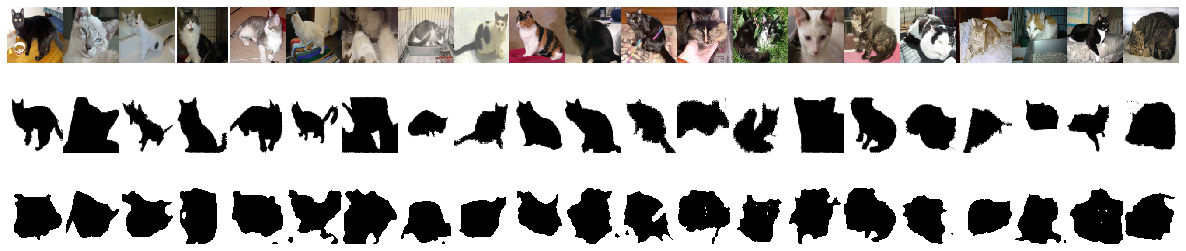

In [16]:
def read_test_images(test_input_dir, test_mask_dir):
    # read images and masks again
    img_ids = [int(f.split('.')[-2]) for f in os.listdir(test_input_dir)]
    first_img = os.listdir(test_input_dir)[0]
    first_mask = os.listdir(test_mask_dir)[0]
    img_name = first_img.split('.')[0]
    img_extension = first_img.split('.')[-1]
    mask_name = first_mask.split('.')[0]
    mask_extension = first_mask.split('.')[-1]
    imgs = []
    masks = []

    for id in img_ids:
        img = Image.open(test_input_dir+img_name+'.'+str(id)+'.'+img_extension)
        mask = Image.open(test_mask_dir+mask_name+'.'+str(id)+'.'+mask_extension)
        imgs.append(transforms.Resize((128, 128))(img))
        masks.append(transforms.Resize((128, 128))(mask))
        
    return imgs, masks

def process_predict_masks(predicts):
    predict_masks = []
    for predict in predicts:
        predict_masks.append((np.asarray(predict) > 255 * 0.5).astype(int) * 255)
    return predict_masks

def show_all_images(imgs, masks, predicts):
    # Get predicted masked from trained model and make them into a numpy array
    for i in range(len(predicts)):
      predicts[i] = ((np.asarray(predicts[i]))).astype(int)

    rows = 3
    cols = len(predicts)  
    fig, axs = plt.subplots(rows, cols, figsize=(21,5))

    for i in range(rows):
      for j in range(cols):
        axs[i, j].axis('off')
        if i is 0:
          axs[i, j].imshow(imgs[j])
          axs[i, j].set_aspect('equal')
        elif i is 1:
          axs[i, j].imshow(masks[j], cmap="Greys")
          axs[i, j].set_aspect('equal')
        elif i is 2:
          axs[i, j].imshow(predicts[j], cmap="Greys")
          axs[i, j].set_aspect('equal')

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    
def show_one_image(img, mask, predict):
    # Get predicted masked from trained model and make them into a numpy array
    predict = ((np.asarray(predict))).astype(int)
    fig, axs = plt.subplots(1, 3, figsize=(21,5))

    axs[0].axis('off')
    axs[0].imshow(img)
    axs[0].set_aspect('equal')

    axs[1].axis('off')
    axs[1].imshow(mask, cmap="Greys")
    axs[1].set_aspect('equal')

    axs[2].axis('off')
    axs[2].imshow(predict, cmap="Greys")
    axs[2].set_aspect('equal')

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

imgs, masks = read_test_images(test_input_dir, test_mask_dir)
predict_masks_dice = process_predict_masks(predicts_dice)
show_all_images(imgs, masks, predict_masks_dice)

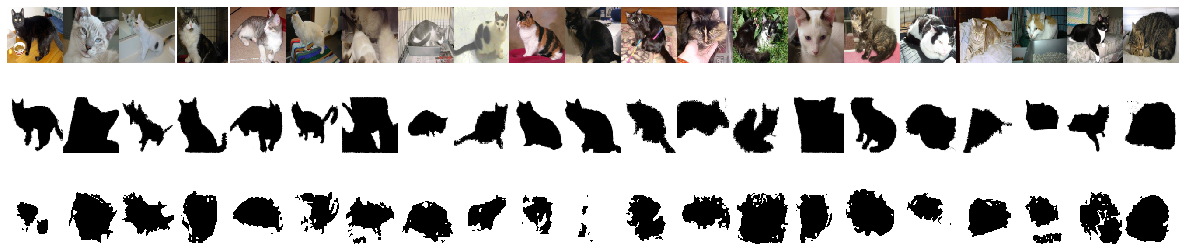

In [17]:
imgs, masks = read_test_images(test_input_dir, test_mask_dir)
predict_masks_bce = process_predict_masks(predicts_bce)
show_all_images(imgs, masks, predict_masks_bce)

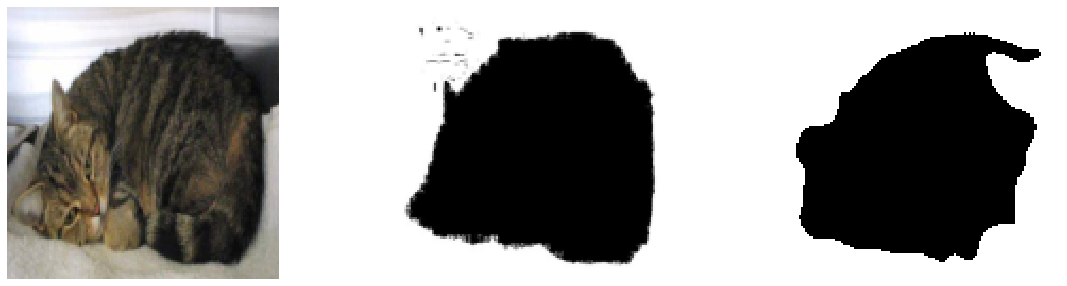

In [18]:
show_one_image(imgs[20], masks[20], predict_masks_dice[20])

# 1.4 Visualizing segmentation predictions

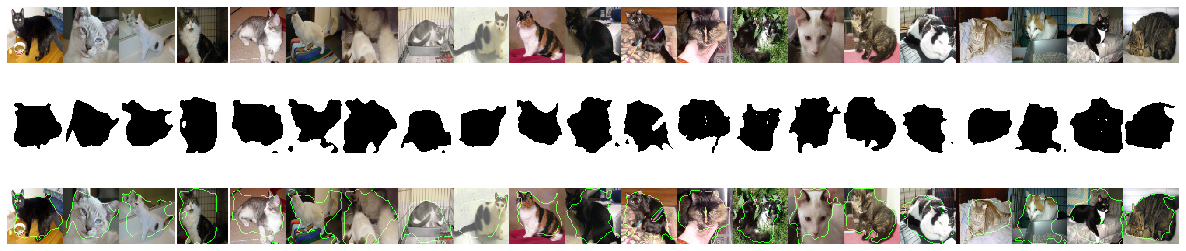

In [19]:
def show_segmentation(imgs, predict_masks):
    predict_segs = []
    for i in range(len(predict_masks)):
        predict = predict_masks[i].astype(float)
        laplacian = cv.Laplacian(predict, cv.CV_64F)

        predict_img = np.asarray(imgs[i]).copy()
        predict_img[laplacian != 0., 1] = 255
        predict_segs.append(predict_img)

    show_all_images(imgs, predict_masks, predict_segs)

def show_single_segmentation(img, predict_mask):
    predict = predict_mask.astype(float)
    laplacian = cv.Laplacian(predict, cv.CV_64F)

    predict_img = np.asarray(img).copy()
    predict_img[laplacian != 0., 1] = 255
    show_one_image(img, predict_mask, predict_img)

show_segmentation(imgs, predict_masks_dice)

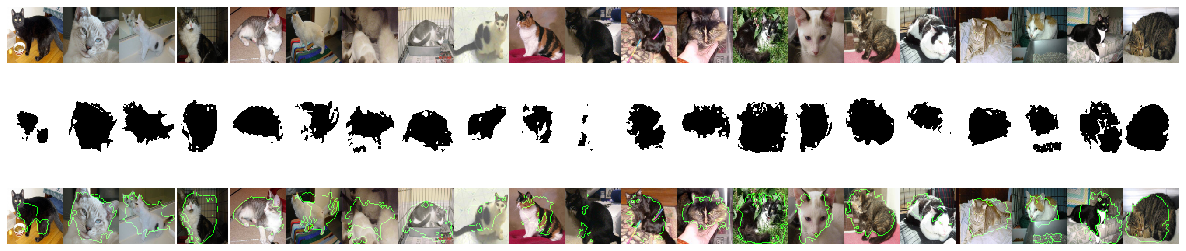

In [20]:
show_segmentation(imgs, predict_masks_bce)